## Multiple Amplitude Matrices
Katherine Elder

When looking at the plots generated in the antenna matrix notebook, we noticed some patterns showing up in the delays. However, it was difficult to see everything that was going when only looking at one amplitude. To try and pick up more patterns, we split up the window of where we are looking for the amplitude peaks in the delay transforms. 

A lot of the maximum amplitudes fall at delay times corresponding to baselines. To look into that more, we find the maximum amplitude for each antenna pair within the window of delays which appear to be baseline dependent. Then we look at the amplitudes for everything that is not baseline dependent. 

In [1]:
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib
#Import the functions I defined for this notebook
import amp_delay_plotting as adp

#Create uv elements
uvxy = UVData()
uvyx = UVData()
uvxx = UVData()
uvyy = UVData()

#Create constant variables
#Variable for the speed of light, with power adjusted for desired units
c = 0.299792
#Variable for speed of light in a cable correction factor, based on Google search
f = .83

#Create an array of antennas we want to flag
flagged_antennas = np.array([0,2,26,50,98,136])

In [2]:
#Read each of the data files into the uv objects

# Read in the xy data file
uvxy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')

# Read in the yx data file
uvyx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/yx_time_split_data/combined_files/zen.grp1.of1.yx.LST.run_8.uvOCRSL.uvfits')

#Read in the xx data file
uvxx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xx_time_split_data/combined_files/zen.grp1.of1.xx.LST.run_2.uvOCRSL.uvfits')

#Read in the yy data file
uvyy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_yy_time_split_data/combined_files/zen.grp1.of1.yy.LST.run_2.uvOCRSL.uvfits')

In [3]:
print "xy nsample mean:", np.mean(uvxy.nsample_array)
print "yx nsample mean:", np.mean(uvyx.nsample_array)
print "xx nsample mean:", np.mean(uvxx.nsample_array)
print "yy nsample mean:", np.mean(uvyy.nsample_array)

print 'xy flags mean:', np.mean(uvxy.flag_array)
print 'yx flags mean:', np.mean(uvyx.flag_array)
print 'xx flags mean:', np.mean(uvxx.flag_array)
print 'yy flags mean:', np.mean(uvyy.flag_array)

xy nsample mean: 30588.262
yx nsample mean: 30966.137
xx nsample mean: 31376.717
yy nsample mean: 25438.166
xy flags mean: 0.34827918065130625
yx flags mean: 0.34021793359941943
xx flags mean: 0.3296763028392598
yy flags mean: 0.3582007154843977


In [4]:
#Read in the position and antenna numbers for all antennas
#These will be passed into functions to plot the antennas in the correct positions
antpos, ants = uvxy.get_ENU_antpos()

In [5]:
#Prompt the user to input the desired antenna
focus_ant = input("Which antenna would you like to look at? Enter here: ")
#Take the input and represent as an integer
focus_ant = int(focus_ant)
#Run a check that the number is valid
focus_ant = adp.check_antnum(antnum = focus_ant, ants = ants)

Which antenna would you like to look at? Enter here: 143
143


We now have all the information we need to create and plot the matrices. 

First, we will look at the baseline dependent amplitudes. These are the maximum amplitudes that fall within the distance of baseline. The longest baseline is ~120 m, so we narrow our window to only find amplitudes within 120 m on either side of the chosen antenna. 

We call the made_array function to create the arrays of amplitudes and delays. Then we call the make_matrix function to correctly format the arrays we just created so they can be plotted. 

Finally, we call the plot_matrix function and pass in all the required information to plot the matrix arrays. 

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


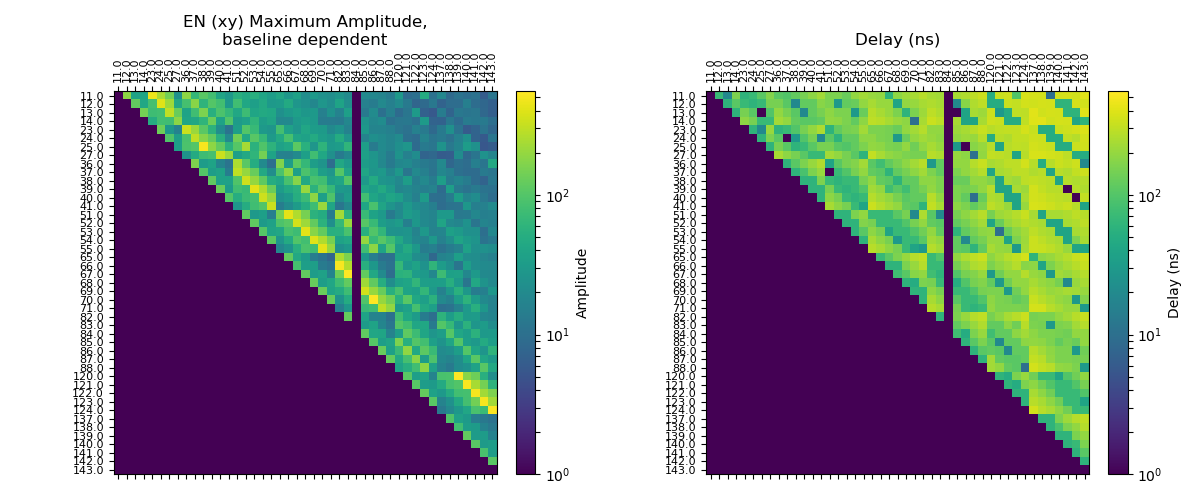

In [6]:
#Call the make_array functions to create the arrays for the baseline dependent amplitudes
blin_amp_xy, blin_delay_xy = adp.make_blin_depd_arrays(uv = uvxy)

#Print the shape of the arrays to check that everything is working correctly
print blin_delay_xy.shape
print blin_amp_xy.shape

blin_amp_matrix_xy, blin_delay_matrix_xy = adp.make_matrix_array(amp_array = blin_amp_xy, 
                                                                 delay_array = blin_delay_xy)

print blin_amp_matrix_xy.shape
print blin_delay_matrix_xy.shape

adp.plot_matrix_array(amp_array = blin_amp_xy, amp_matrix = blin_amp_matrix_xy, delay_matrix = blin_delay_matrix_xy,
                      vmin1 = 1, vmax1 = 550, vmin2 = 1, vmax2 = 550,
                      title = 'EN (xy) Maximum Amplitude,\nbaseline dependent')

<IPython.core.display.Javascript object>


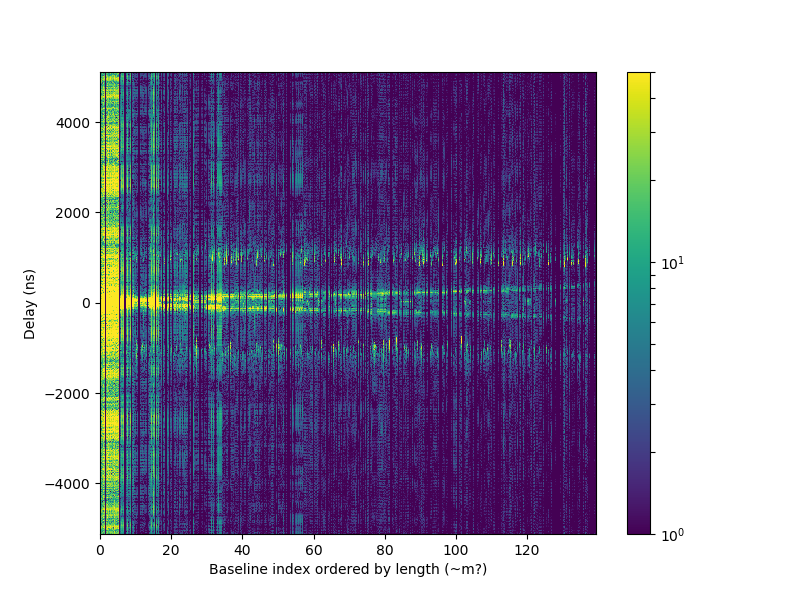

((1024, 1378), (1024, 1378), (1024, 1378))


In [7]:
blin_len = np.sqrt(np.diag(np.dot(uvxy.uvw_array, uvxy.uvw_array.T)))
blins_inds = np.argsort(blin_len)

uvxy_delay = np.fft.fft(uvxy.data_array,axis=2).squeeze()

uvxy_delay = uvxy_delay[blins_inds].T

freq_width = np.diff(uvxy.freq_array[0,:])[0]

delays = np.fft.fftfreq(uvxy.Nfreqs,freq_width)*1e9
#print(uvxy_delay.shape)
#print(uvx.uvw_array.shape)
#print(blin_len.shape)
#print(delays.shape)
plt.figure(figsize=(8,6))
BL_LENGTHS,DELAYS = np.meshgrid(blin_len,np.fft.fftshift(delays))
print(BL_LENGTHS.shape,DELAYS.shape,uvxy_delay.shape)
#plt.pcolor(BL_LENGTHS,DELAYS,np.fft.fftshift(uvxy_delay,axes=1), 
#           norm=SymLogNorm(vmin=0.1,vmax=100,linthresh=0.1))
plt.imshow(np.abs(np.fft.fftshift(uvxy_delay,axes=0)),
               aspect='auto',norm=SymLogNorm(vmin=1,vmax=50,linthresh=0.2),
               extent=(blin_len.min(),blin_len.max(),delays.min(),delays.max()))
plt.xlabel('Baseline index ordered by length (~m?)')
plt.ylabel('Delay (ns)')
plt.colorbar()



<IPython.core.display.Javascript object>


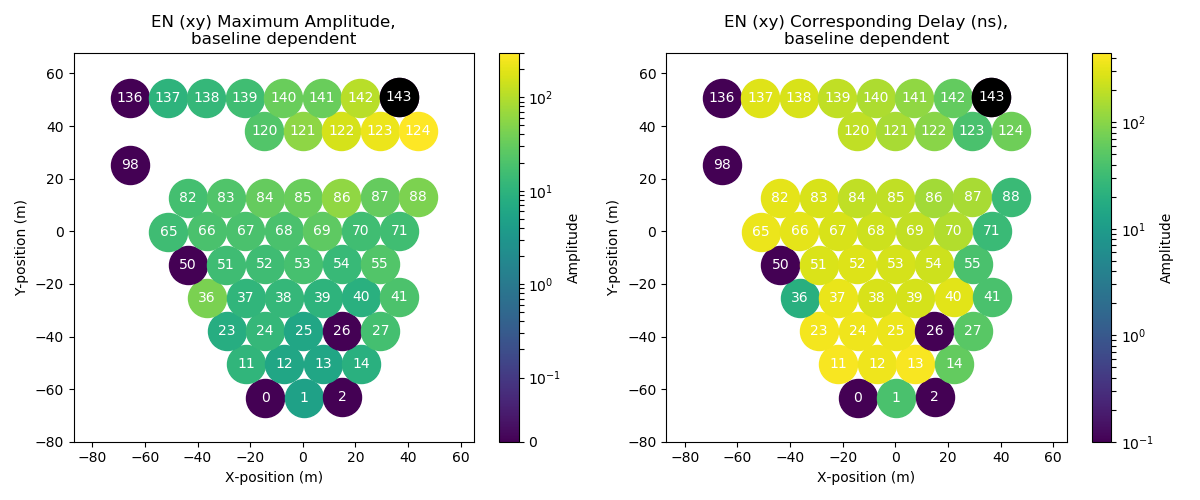

In [39]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_amp_xy, full_ant_delay_xy = adp.make_blin_depd_arrays(uv = uvxy, keep_flags = True)
blin_ants_amp_xy, blin_ants_delay_xy, index, dindex = adp.make_matrix_array(amp_array = full_ant_amp_xy, 
                                                                            delay_array = full_ant_delay_xy, 
                                                                            antnum = focus_ant, index = True)

adp.plot_position_array(amp_array = blin_ants_amp_xy, delay_array = blin_ants_delay_xy, 
                        index = index, dindex = dindex, uv = uvxy, antnum = focus_ant,
                        vmin1 = 0, vmax1 = 300, 
                        vmin2 = 0.1, vmax2 = 450, 
                        title1 = 'EN (xy) Maximum Amplitude,\nbaseline dependent',
                        title2 = 'EN (xy) Corresponding Delay (ns),\nbaseline dependent')

We've been able to isolate the amplitudes that are baseline dependent, now it's time to look at everything else. 

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


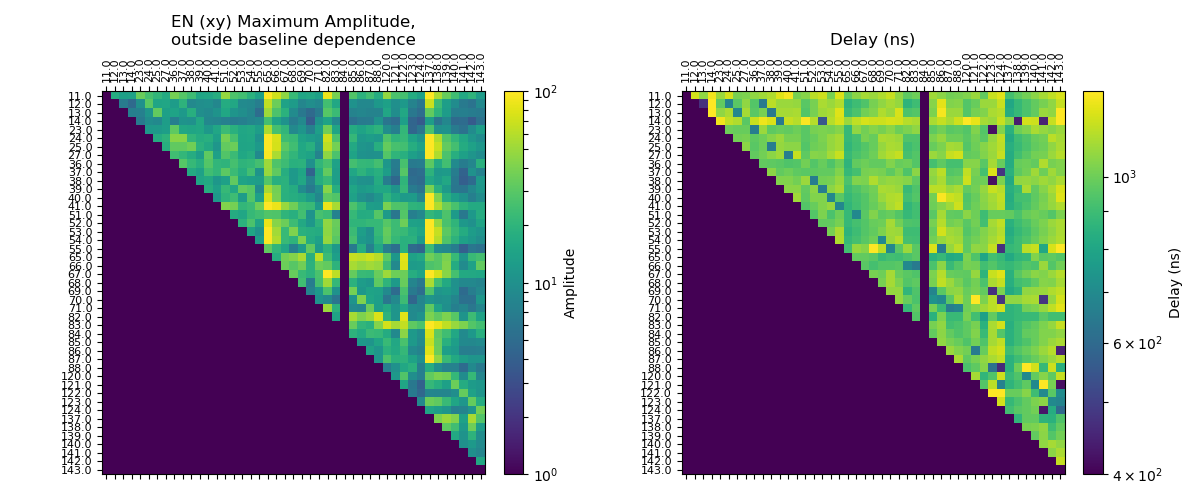

In [9]:
ind_amp_xy, ind_delay_xy = adp.make_blin_ind_arrays(uv = uvxy)

print ind_delay_xy.shape
print ind_amp_xy.shape

ind_amp_matrix_xy, ind_delay_matrix_xy = adp.make_matrix_array(amp_array = ind_amp_xy, delay_array = ind_delay_xy)

print ind_amp_matrix_xy.shape
print ind_delay_matrix_xy.shape

adp.plot_matrix_array(amp_array = ind_amp_xy, amp_matrix = ind_amp_matrix_xy, delay_matrix = ind_delay_matrix_xy,
                      vmin1 = 1, vmax1 = 100,
                      vmin2 = 400, vmax2 = 1300,
                      title = 'EN (xy) Maximum Amplitude,\noutside baseline dependence')

<IPython.core.display.Javascript object>


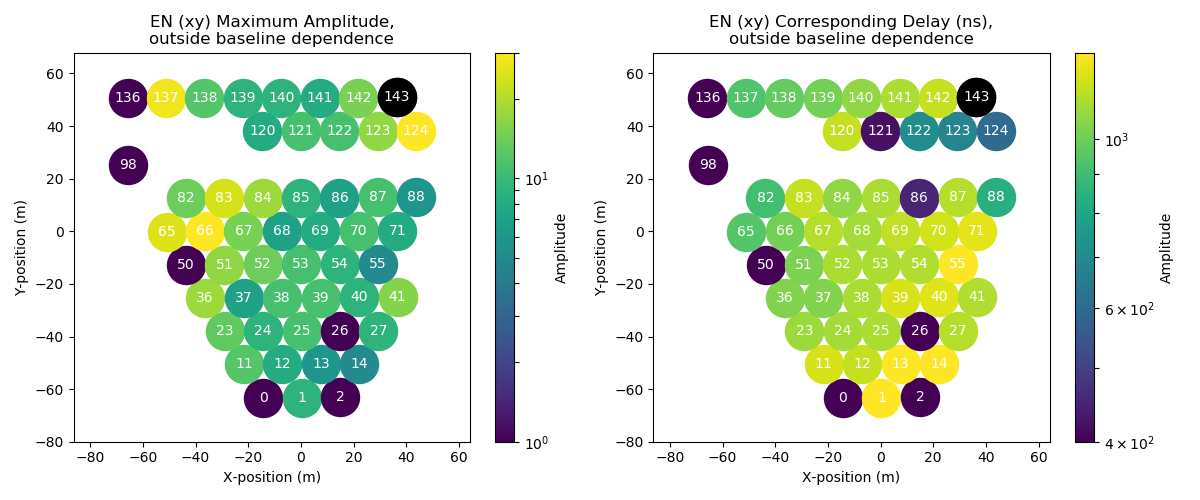

In [40]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_ind_amp_xy, full_ant_ind_delay_xy = adp.make_blin_ind_arrays(uv = uvxy, keep_flags=True)
ind_ants_amp_xy, ind_ants_delay_xy, index_ind, dindex_ind = adp.make_matrix_array(amp_array = full_ant_ind_amp_xy, 
                                                                                  delay_array = full_ant_ind_delay_xy, 
                                                                                  antnum = focus_ant, 
                                                                                  index = True)

adp.plot_position_array(amp_array = ind_ants_amp_xy, delay_array = ind_ants_delay_xy,
                        index = index_ind, dindex = dindex_ind, uv = uvxy, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 30,
                        vmin2 = 400, vmax2 = 1300, 
                        title1 = 'EN (xy) Maximum Amplitude,\noutside baseline dependence',
                        title2 = 'EN (xy) Corresponding Delay (ns),\noutside baseline dependence')

<IPython.core.display.Javascript object>


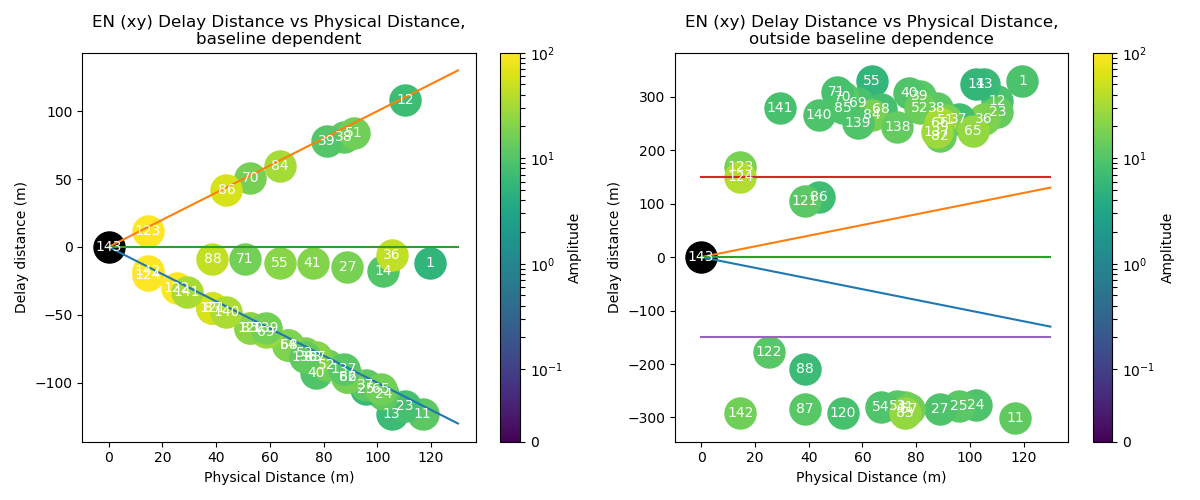

In [41]:
#Create an array which holds the delay times in meters
blin_delay_distance = blin_ants_delay_xy * c
#Create an array which holds the delay times in meters
ind_delay_distance = ind_ants_delay_xy * c * f

adp.plot_delay_position(amp_1 = blin_ants_amp_xy, delay_dis_1 = blin_delay_distance,
                        amp_2 = ind_ants_amp_xy, delay_dis_2 = ind_delay_distance,
                        index1 = index, index2 = index_ind, uv = uvxy, antnum = focus_ant,
                        vmin1 = 0, vmax1 = 100, 
                        vmin2 = 0, vmax2 = 100,
                        title1 = 'EN (xy) Delay Distance vs Physical Distance,\nbaseline dependent',
                        title2 = 'EN (xy) Delay Distance vs Physical Distance,\noutside baseline dependence')

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


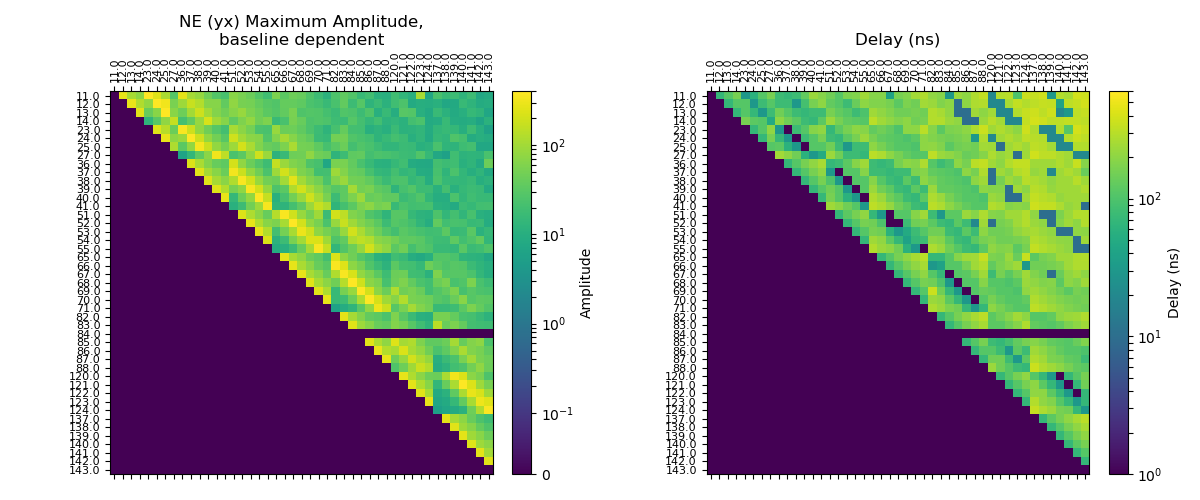

In [12]:
blin_amp_yx, blin_delay_yx = adp.make_blin_depd_arrays(uv = uvyx)

print blin_delay_yx.shape
print blin_amp_yx.shape

blin_amp_matrix_yx, blin_delay_matrix_yx = adp.make_matrix_array(amp_array = blin_amp_yx, 
                                                                 delay_array = blin_delay_yx)

print blin_amp_matrix_yx.shape
print blin_delay_matrix_yx.shape

adp.plot_matrix_array(amp_array = blin_amp_yx, amp_matrix = blin_amp_matrix_yx, delay_matrix = blin_delay_matrix_yx,
                      vmin1 = 0, vmax1 = 400,
                      vmin2 = 1, vmax2 = 600, 
                      title = 'NE (yx) Maximum Amplitude,\nbaseline dependent')

<IPython.core.display.Javascript object>


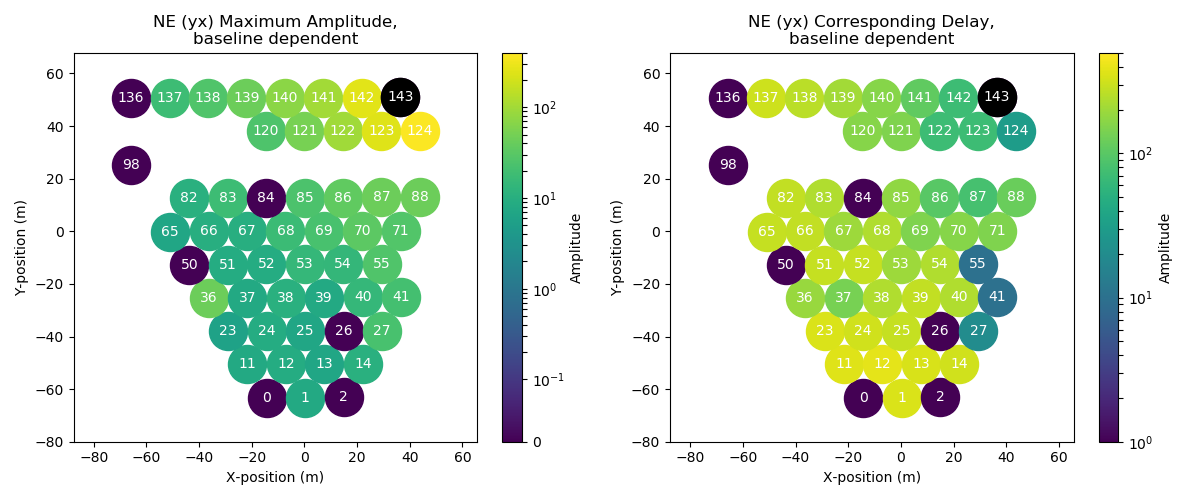

In [42]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_amp_yx, full_ant_delay_yx = adp.make_blin_depd_arrays(uv = uvyx, keep_flags=True)
blin_ants_amp_yx, blin_ants_delay_yx, indeyx, dindeyx = adp.make_matrix_array(amp_array = full_ant_amp_yx, 
                                                                              delay_array=full_ant_delay_yx, 
                                                                              antnum = focus_ant, index = True)

adp.plot_position_array(amp_array = blin_ants_amp_yx, delay_array = blin_ants_delay_yx,
                        index = indeyx, dindex = dindeyx, uv = uvyx, antnum = focus_ant,
                        vmin1 = 0, vmax1 = 400,
                        vmin2 = 1, vmax2 = 500, 
                        title1 = 'NE (yx) Maximum Amplitude,\nbaseline dependent',
                        title2 = 'NE (yx) Corresponding Delay,\nbaseline dependent')

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


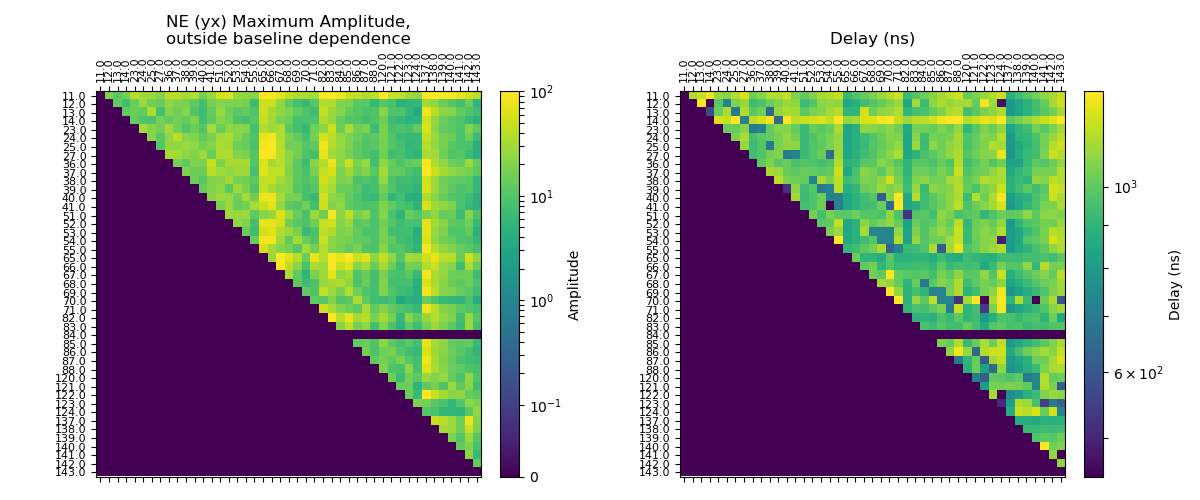

In [14]:
ind_amp_yx, ind_delay_yx = adp.make_blin_ind_arrays(uv = uvyx)

print ind_delay_yx.shape
print ind_amp_yx.shape

ind_amp_matrix_yx, ind_delay_matrix_yx = adp.make_matrix_array(amp_array = ind_amp_yx, delay_array = ind_delay_yx)

print ind_amp_matrix_yx.shape
print ind_delay_matrix_yx.shape

adp.plot_matrix_array(amp_array = ind_amp_yx, amp_matrix = ind_amp_matrix_yx, delay_matrix = ind_delay_matrix_yx,
                      vmin1 = 0, vmax1 = 100,
                      vmin2 = 450, vmax2 = 1300, 
                      title = 'NE (yx) Maximum Amplitude,\noutside baseline dependence')

<IPython.core.display.Javascript object>


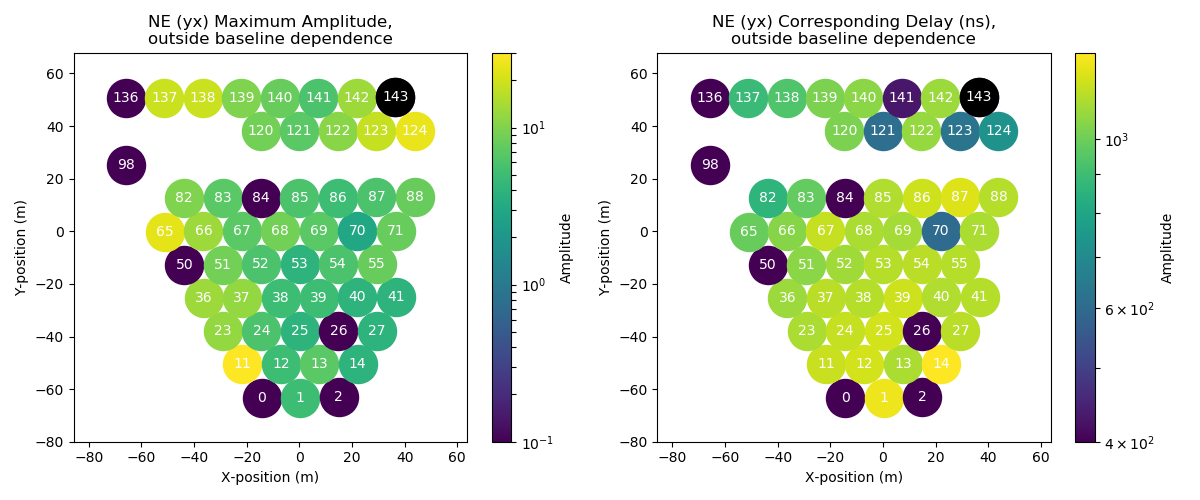

In [43]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_ind_amp_yx, full_ant_ind_delay_yx = adp.make_blin_ind_arrays(uv = uvyx, keep_flags=True)
ind_ants_amp_yx, ind_ants_delay_yx, indeyx_ind, dindeyx_ind = adp.make_matrix_array(amp_array = full_ant_ind_amp_yx, 
                                                                                    delay_array = full_ant_ind_delay_yx, 
                                                                                    antnum = focus_ant, index = True)

adp.plot_position_array(amp_array = ind_ants_amp_yx, delay_array = ind_ants_delay_yx,
                        index = indeyx_ind, dindex = dindeyx_ind, uv = uvyx, antnum = focus_ant,
                        vmin1 = .1, vmax1 = 30,
                        vmin2 = 400, vmax2 = 1300, 
                        title1 = 'NE (yx) Maximum Amplitude,\noutside baseline dependence',
                        title2 = 'NE (yx) Corresponding Delay (ns),\noutside baseline dependence')

<IPython.core.display.Javascript object>


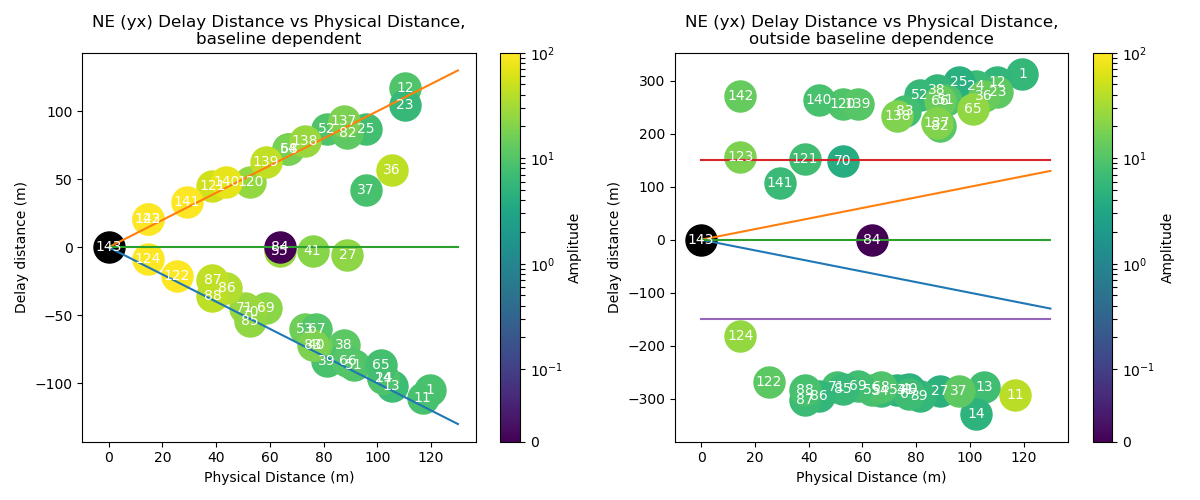

In [44]:
#Create an array which holds the delay times in meters
blin_delay_distance_yx = blin_ants_delay_yx * c

#Create an array which holds the delay times in meters
ind_delay_distance_yx = ind_ants_delay_yx * c * f

adp.plot_delay_position(amp_1 = blin_ants_amp_yx, delay_dis_1 = blin_delay_distance_yx,
                        amp_2 = ind_ants_amp_yx, delay_dis_2 = ind_delay_distance_yx,
                        index1 = indeyx, index2 = indeyx_ind, uv = uvyx, antnum = focus_ant,
                        vmin1 = 0, vmax1 = 100,
                        vmin2 = 0, vmax2 = 100,
                        title1 = 'NE (yx) Delay Distance vs Physical Distance,\nbaseline dependent',
                        title2 = 'NE (yx) Delay Distance vs Physical Distance,\noutside baseline dependence')


(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


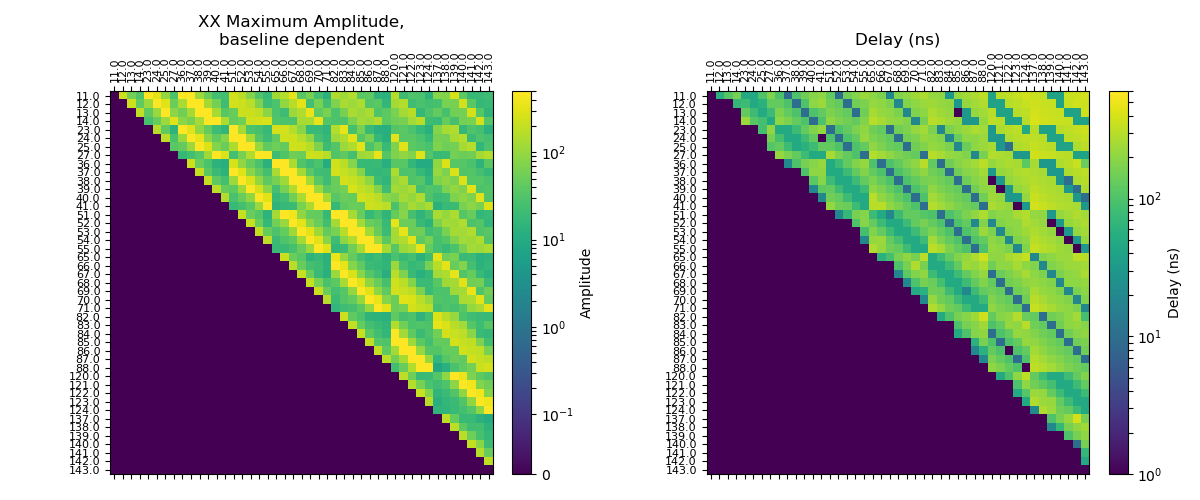

In [17]:
blin_amp_xx,blin_delay_xx = adp.make_blin_depd_arrays(uv = uvxx)

print blin_delay_xx.shape
print blin_amp_xx.shape

blin_amp_matrix_xx, blin_delay_matrix_xx = adp.make_matrix_array(amp_array = blin_amp_xx, 
                                                                 delay_array = blin_delay_xx)

print blin_amp_matrix_xx.shape
print blin_delay_matrix_xx.shape

adp.plot_matrix_array(amp_array = blin_amp_xx, amp_matrix=blin_amp_matrix_xx, delay_matrix = blin_delay_matrix_xx,
                      vmin1 = 0, vmax1 = 500,
                      vmin2 = 1, vmax2 = 600, 
                      title = 'XX Maximum Amplitude,\nbaseline dependent')

<IPython.core.display.Javascript object>


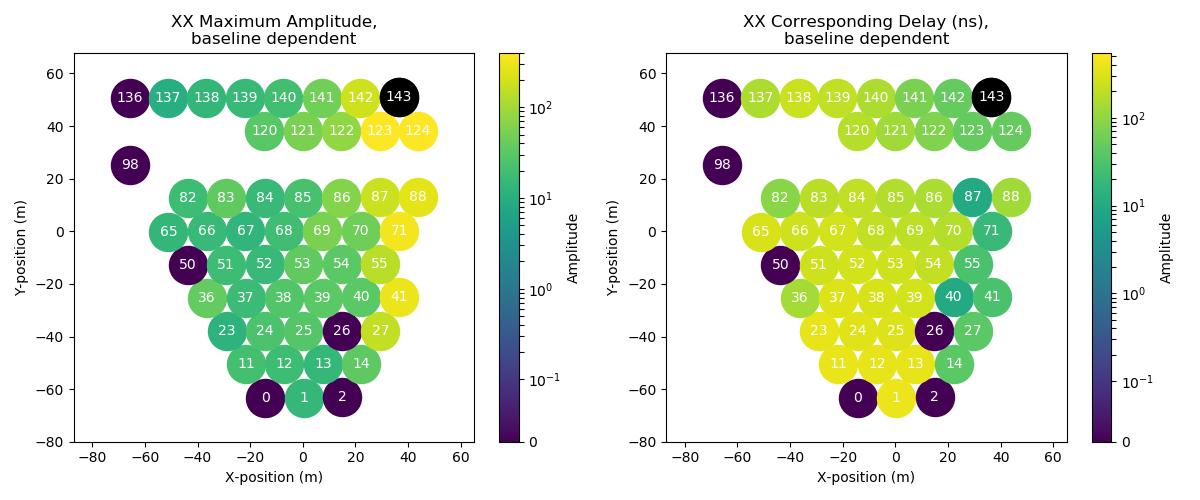

In [45]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_amp_xx, full_ant_delay_xx = adp.make_blin_depd_arrays(uv = uvxx, keep_flags=True)
blin_ants_amp_xx, blin_ants_delay_xx, indexx, dindexx = adp.make_matrix_array(amp_array = full_ant_amp_xx, 
                                                                              delay_array = full_ant_delay_xx, 
                                                                              antnum = focus_ant, index = True)

adp.plot_position_array(amp_array = blin_ants_amp_xx, delay_array = blin_ants_delay_xx, 
                        index = indexx, dindex = dindexx, uv = uvxx, antnum = focus_ant,
                        vmin1 = 0, vmax1 = 400,
                        vmin2 = 0, vmax2 = 550,  
                        title1 = 'XX Maximum Amplitude,\nbaseline dependent',
                        title2 = 'XX Corresponding Delay (ns),\nbaseline dependent')

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


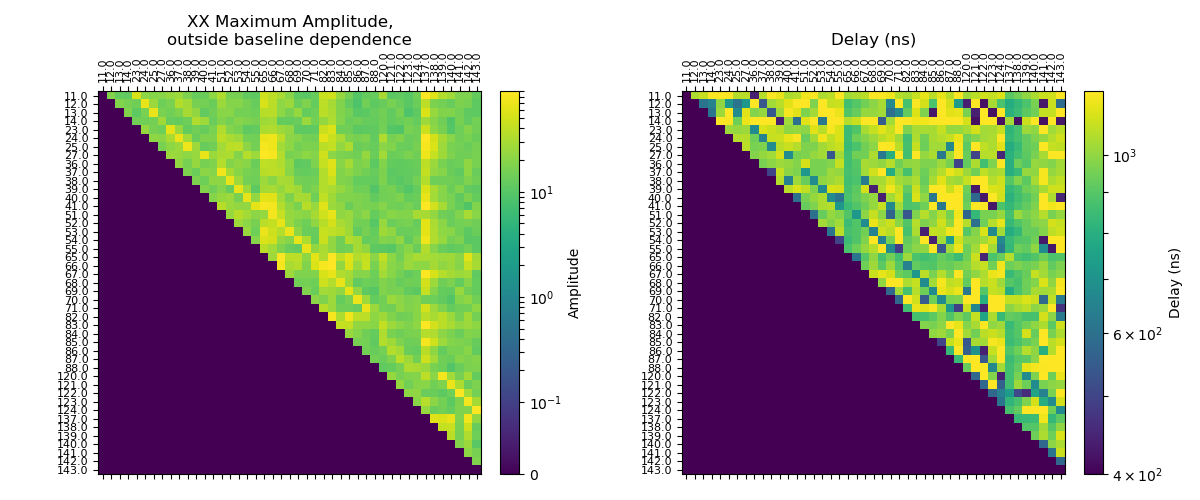

In [19]:
ind_amp_xx, ind_delay_xx = adp.make_blin_ind_arrays(uv = uvxx)

print ind_delay_xx.shape
print ind_amp_xx.shape

ind_amp_matrix_xx, ind_delay_matrix_xx = adp.make_matrix_array(amp_array = ind_amp_xx, delay_array = ind_delay_xx)

print ind_amp_matrix_xx.shape
print ind_delay_matrix_xx.shape

adp.plot_matrix_array(amp_array = ind_amp_xx, amp_matrix = ind_amp_matrix_xx, delay_matrix = ind_delay_matrix_xx,
                      vmin1 = 0, vmax1 = 90,
                      vmin2 = 400, vmax2 = 1200, 
                      title = 'XX Maximum Amplitude,\noutside baseline dependence')

<IPython.core.display.Javascript object>


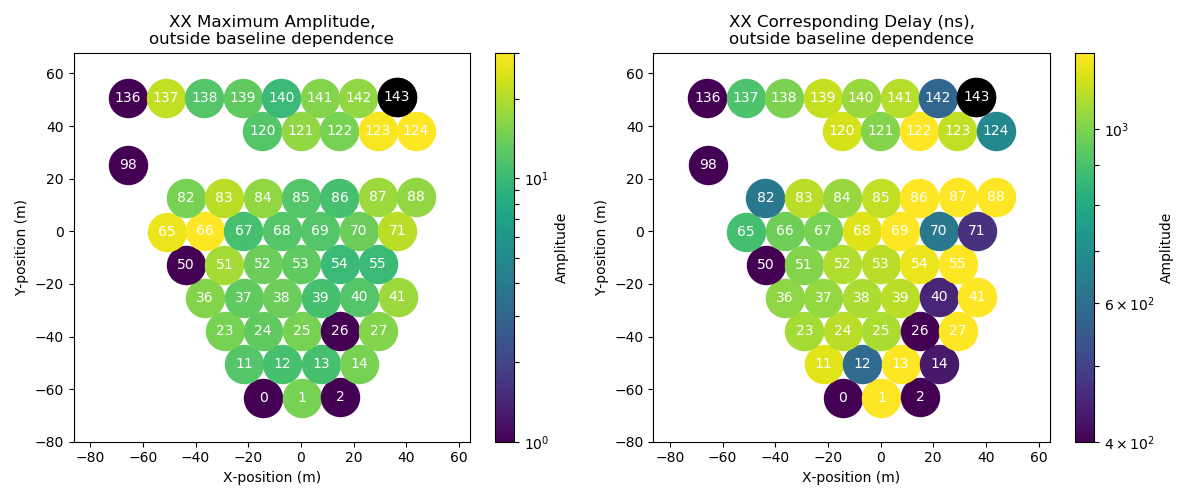

In [46]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_ind_amp_xx, full_ant_ind_delay_xx = adp.make_blin_ind_arrays(uv = uvxx, keep_flags=True)
ind_ants_amp_xx, ind_ants_delay_xx, indexx_ind, dindexx_ind = adp.make_matrix_array(amp_array = full_ant_ind_amp_xx,
                                                                                    delay_array = full_ant_ind_delay_xx, 
                                                                                    antnum = focus_ant, index = True)

adp.plot_position_array(amp_array = ind_ants_amp_xx, delay_array = ind_ants_delay_xx,
                        index = indexx_ind, dindex = dindexx_ind, uv = uvxx, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 30,
                        vmin2 = 400, vmax2 = 1250,  
                        title1 = 'XX Maximum Amplitude,\noutside baseline dependence',
                        title2 = 'XX Corresponding Delay (ns),\noutside baseline dependence')

<IPython.core.display.Javascript object>


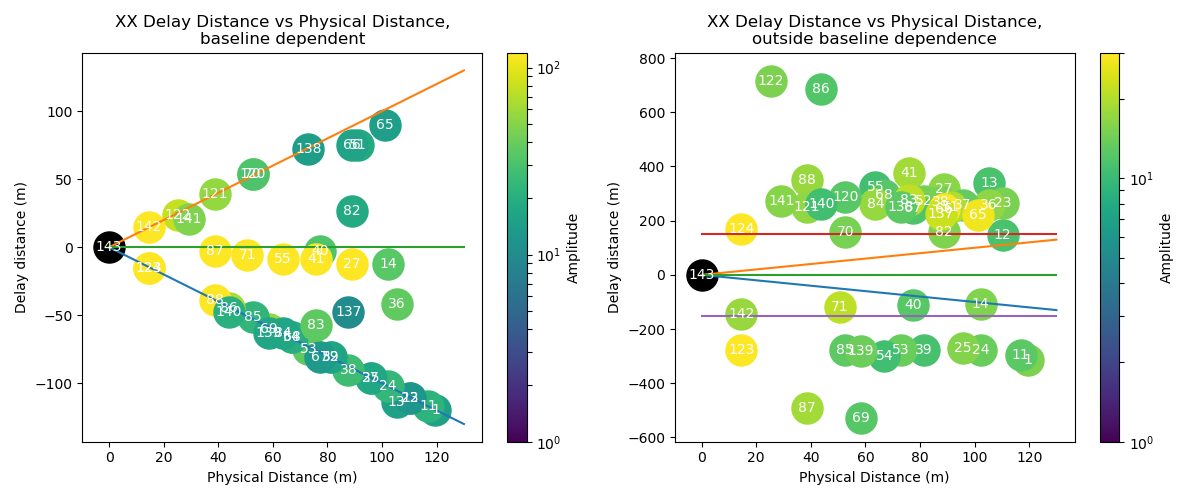

In [47]:
#Create an array which holds the delay times in meters
blin_delay_distance_xx = blin_ants_delay_xx * c

#Create an array which holds the delay times in meters
ind_delay_distance_xx = ind_ants_delay_xx * c * f

adp.plot_delay_position(amp_1 = blin_ants_amp_xx, delay_dis_1 = blin_delay_distance_xx, 
                        amp_2 = ind_ants_amp_xx, delay_dis_2 = ind_delay_distance_xx,
                        index1 = indexx, index2 = indexx_ind, uv = uvxx, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 120,
                        vmin2 = 1, vmax2 = 30,
                        title1 = 'XX Delay Distance vs Physical Distance,\nbaseline dependent',
                        title2 = 'XX Delay Distance vs Physical Distance,\noutside baseline dependence')


(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


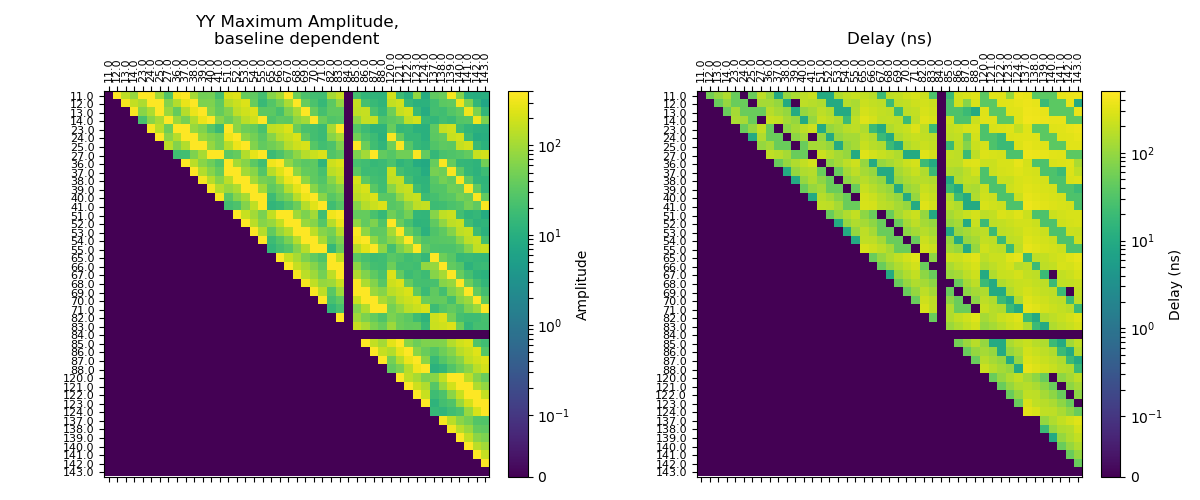

In [22]:
blin_amp_yy, blin_delay_yy = adp.make_blin_depd_arrays(uv = uvyy)

print blin_delay_yy.shape
print blin_amp_yy.shape

blin_amp_matrix_yy, blin_delay_matrix_yy = adp.make_matrix_array(amp_array = blin_amp_yy, 
                                                                 delay_array = blin_delay_yy)

print blin_amp_matrix_yy.shape
print blin_delay_matrix_yy.shape

adp.plot_matrix_array(amp_array = blin_amp_yy, amp_matrix = blin_amp_matrix_yy, delay_matrix = blin_delay_matrix_yy,
                      vmin1 = 0, vmax1 =400,
                      vmin2 = 0, vmax2 = 500,
                      title='YY Maximum Amplitude,\nbaseline dependent')

<IPython.core.display.Javascript object>


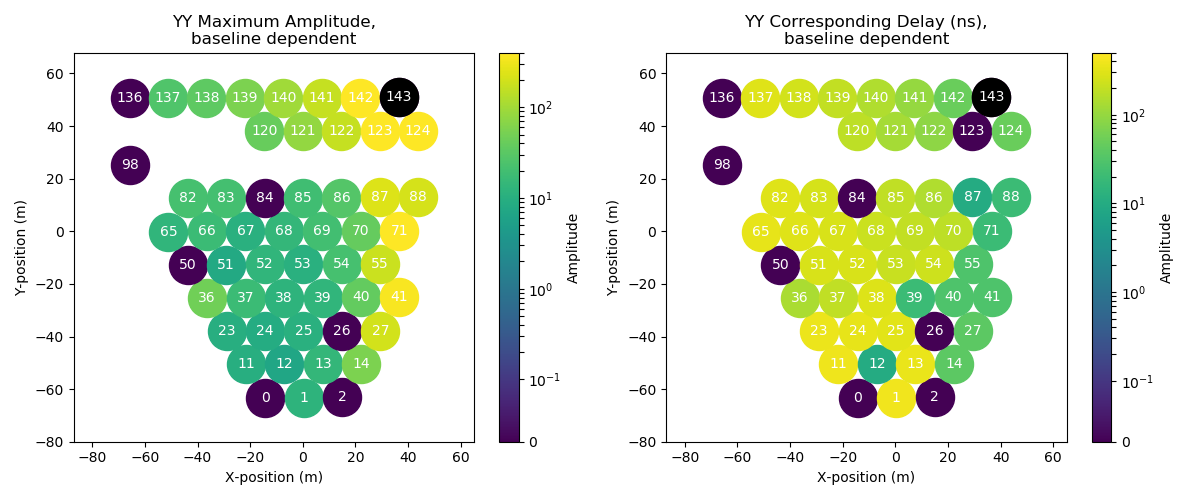

In [48]:
#Create the arrays for the maximum values and the matrix for yy
full_ant_amp_yy, full_ant_delay_yy = adp.make_blin_depd_arrays(uv = uvyy, keep_flags=True)
blin_ants_amp_yy, blin_ants_delay_yy, indeyy, dindeyy = adp.make_matrix_array(amp_array = full_ant_amp_yy, 
                                                                              delay_array = full_ant_delay_yy, 
                                                                              antnum = focus_ant, index = True)

adp.plot_position_array(amp_array = blin_ants_amp_yy, delay_array = blin_ants_delay_yy,
                        index = indeyy, dindex = dindeyy, uv = uvyy, antnum = focus_ant,
                        vmin1 = 0, vmax1 = 400,
                        vmin2 = 0, vmax2 = 500,
                        title1 = 'YY Maximum Amplitude,\nbaseline dependent',
                        title2 = 'YY Corresponding Delay (ns),\nbaseline dependent')

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


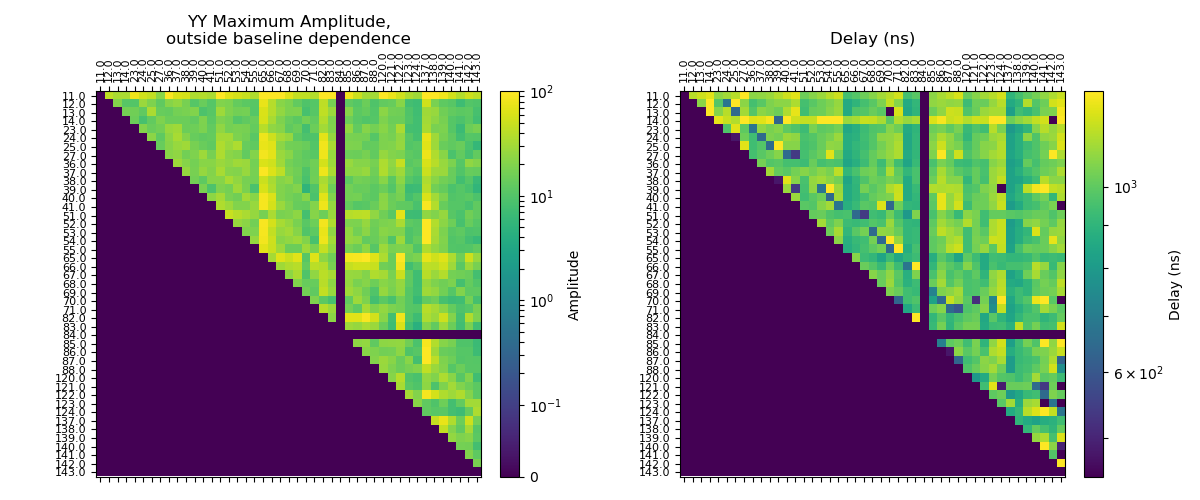

In [24]:
ind_amp_yy,ind_delay_yy = adp.make_blin_ind_arrays(uv = uvyy)

print ind_delay_yy.shape
print ind_amp_yy.shape

ind_amp_matrix_yy, ind_delay_matrix_yy = adp.make_matrix_array(amp_array = ind_amp_yy, delay_array = ind_delay_yy)

print ind_amp_matrix_yy.shape
print ind_delay_matrix_yy.shape

adp.plot_matrix_array(amp_array = ind_amp_yy, amp_matrix = ind_amp_matrix_yy, delay_matrix = ind_delay_matrix_yy,
                      vmin1 = 0, vmax1 = 100,
                      vmin2 = 450, vmax2 = 1300, 
                      title = 'YY Maximum Amplitude,\noutside baseline dependence')

<IPython.core.display.Javascript object>


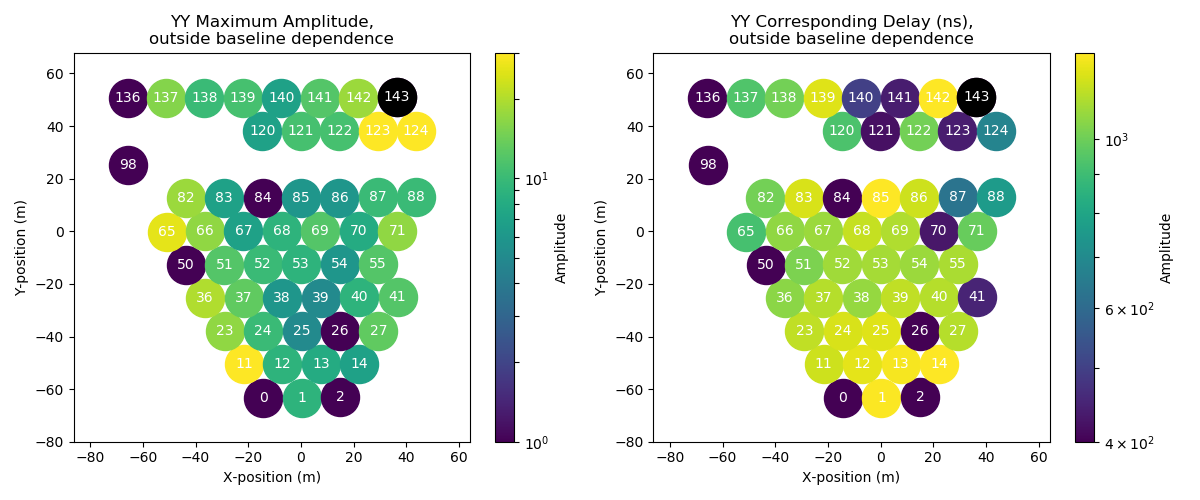

In [49]:
#Create the arrays for the maximum values and the matrix for xy
full_ant_ind_amp_yy, full_ant_ind_delay_yy = adp.make_blin_ind_arrays(uv = uvyy, keep_flags=True)
ind_ants_amp_yy, ind_ants_delay_yy, indeyy_ind, dindeyy_ind = adp.make_matrix_array(amp_array = full_ant_ind_amp_yy,
                                                                                    delay_array = full_ant_ind_delay_yy,
                                                                                    antnum = focus_ant, index = True)

adp.plot_position_array(amp_array = ind_ants_amp_yy, delay_array = ind_ants_delay_yy,
                        index = indeyy_ind, dindex = dindeyy_ind, uv = uvyy, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 30,
                        vmin2 = 400, vmax2 = 1300,  
                        title1 = 'YY Maximum Amplitude,\noutside baseline dependence',
                        title2 = 'YY Corresponding Delay (ns),\noutside baseline dependence')

<IPython.core.display.Javascript object>


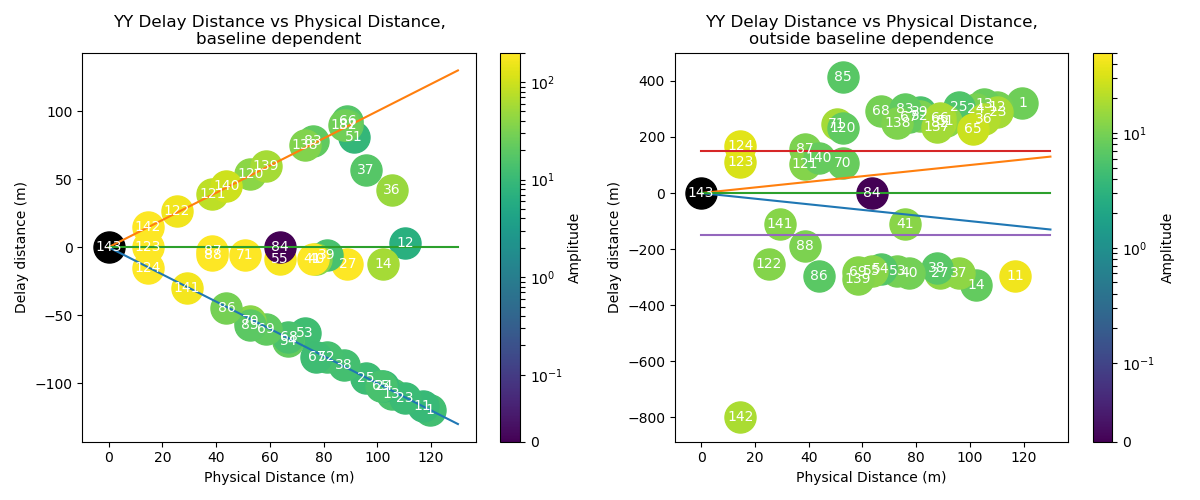

In [50]:
#Create an array which holds the delay times in meters
blin_delay_distance_yy = blin_ants_delay_yy * c

#Create an array which holds the delay times in meters
ind_delay_distance_yy = ind_ants_delay_yy * c * f

adp.plot_delay_position(amp_1 = blin_ants_amp_yy, delay_dis_1 = blin_delay_distance_yy,
                        amp_2 = ind_ants_amp_yy, delay_dis_2 = ind_delay_distance_yy,
                        index1 = indeyy, index2 = indeyy_ind, uv = uvyy, antnum = focus_ant,
                        vmin1 = 0, vmax1 = 200,
                        vmin2 = 0, vmax2 = 50,
                        title1 = 'YY Delay Distance vs Physical Distance,\nbaseline dependent',
                        title2 = 'YY Delay Distance vs Physical Distance,\noutside baseline dependence')


To make the movie: 

ffmpeg -framerate 2 -pattern_type glob -i '∗∗.png' -c:v libx264 -pix_fmt yuv420p out.mp4

In [27]:
"""
for focus_ant in ants:
    #Create the arrays for the maximum values and the matrix for xy
    #full_ant_amp_yy, full_ant_delay_yy = adp.make_blin_depd_arrays(uv = uvxy, keep_flags=True)
    ind_ants_amp_xx, ind_ants_delay_xx, indeyx_ind, dindeyx_ind = adp.make_matrix_array(amp_array = full_ant_ind_amp_yy, 
                                                                              delay_array = full_ant_ind_delay_yy, 
                                                                              antnum = focus_ant, index = True)

    adp.plot_position_array(amp_array = ind_ants_amp_xx, delay_array = ind_ants_delay_xx,
                        index = indeyx_ind, dindex = dindeyx_ind, uv = uvyy,
                        vmin1 = 1, vmax1 = 90,
                        vmin2 = 450, vmax2 = 1200,
                        title1 = 'YY Maximum Amplitude,\noutside baseline dependence',
                        title2 = 'YY Corresponding Delay (ns),\noutside baseline dependence')

    if len(str(focus_ant))==1:
        imname = '00' + str(focus_ant) + '_yy.png'
    elif len(str(focus_ant))==2:
        imname = '0' + str(focus_ant) + '_yy.png'
    else: 
        imname = str(focus_ant) + '_yy.png'
    plt.savefig('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/ant_array_imgs/yy_blin_ind_imgs2/'+imname)
"""

"\nfor focus_ant in ants:\n    #Create the arrays for the maximum values and the matrix for xy\n    #full_ant_amp_yy, full_ant_delay_yy = adp.make_blin_depd_arrays(uv = uvxy, keep_flags=True)\n    ind_ants_amp_xx, ind_ants_delay_xx, indeyx_ind, dindeyx_ind = adp.make_matrix_array(amp_array = full_ant_ind_amp_yy, \n                                                                              delay_array = full_ant_ind_delay_yy, \n                                                                              antnum = focus_ant, index = True)\n\n    adp.plot_position_array(amp_array = ind_ants_amp_xx, delay_array = ind_ants_delay_xx,\n                        index = indeyx_ind, dindex = dindeyx_ind, uv = uvyy,\n                        vmin1 = 1, vmax1 = 90,\n                        vmin2 = 450, vmax2 = 1200,\n                        title1 = 'YY Maximum Amplitude,\noutside baseline dependence',\n                        title2 = 'YY Corresponding Delay (ns),\noutside baseline dependence')\n

In [68]:
#Create the delay spectrum for all four polarizations

ant1 = 142
ant2 = 143

vis = uvyy.get_data(ant1,ant2)
print vis
print vis.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay = np.fft.fftshift(np.fft.fft(np.mean(vis,axis=0)))
print vis_avg_delay
print vis_avg_delay.shape

# 2) Find the frequency width of a channel in GHz
freq_width = np.diff(uvyy.freq_array[0,:])[0]
print freq_width

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays = np.fft.fftshift(np.fft.fftfreq(uvyy.Nfreqs,freq_width))*1e9
print delays
print delays.shape

print np.max(np.abs(vis_avg_delay))
print delays[np.argmax(np.abs(vis_avg_delay))]

visxx = uvxx.get_data(ant1,ant2)
print visxx
print visxx.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delayxx = np.fft.fftshift(np.fft.fft(np.mean(visxx,axis=0)))
print vis_avg_delayxx
print vis_avg_delayxx.shape

# 2) Find the frequency width of a channel in GHz
freq_widthxx = np.diff(uvxx.freq_array[0,:])[0]
print freq_widthxx

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delaysxx = np.fft.fftshift(np.fft.fftfreq(uvxx.Nfreqs,freq_widthxx))*1e9
print delaysxx
print delaysxx.shape

print np.max(np.abs(vis_avg_delayxx))
print delaysxx[np.argmax(np.abs(vis_avg_delayxx))]

visxy = uvxy.get_data(ant1,ant2)
print visxy
print visxy.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delayxy = np.fft.fftshift(np.fft.fft(np.mean(visxy,axis=0)))
print vis_avg_delayxy
print vis_avg_delayxy.shape

# 2) Find the frequency width of a channel in GHz
freq_widthxy = np.diff(uvxy.freq_array[0,:])[0]
print freq_widthxy

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delaysxy = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_widthxy))*1e9
print delaysxy
print delaysxy.shape

print np.max(np.abs(vis_avg_delayxy))
print delaysxy[np.argmax(np.abs(vis_avg_delayxy))]

visyx = uvyx.get_data(ant1,ant2)
print visyx
print visyx.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delayyx = np.fft.fftshift(np.fft.fft(np.mean(visyx,axis=0)))
print vis_avg_delayyx
print vis_avg_delayyx.shape

# 2) Find the frequency width of a channel in GHz
freq_widthyx = np.diff(uvyx.freq_array[0,:])[0]
print freq_widthyx

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delaysyx = np.fft.fftshift(np.fft.fftfreq(uvyx.Nfreqs,freq_widthyx))*1e9
print delaysyx
print delaysyx.shape

print np.max(np.abs(vis_avg_delayyx))
print delaysyx[np.argmax(np.abs(vis_avg_delayyx))]

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(1, 1024)
[-0.9618759 -4.5941925j -5.5978804 -4.17829j   -4.1721306 -2.183937j  ...
  7.7617216 -1.4832306j  3.8739128 -4.6774597j  0.23469543-7.506027j ]
(1024,)
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
(1024,)
442.20438
50.0
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(1, 1024)
[-1.8113861 -2.3173904j  -2.108467  -3.7609024j  -4.444521  +0.03124237j
 ...  6.02845   +2.828044j    7.284601  -4.409134j
  0.17586517-8.067005j  ]
(1024,)
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
(1024,)
191.87941
50.0
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(1, 1024)
[-1.1319165 +0.33827972j  2.5514426 +0.5289614j  -0.55209064-1.5543652j
 ... -1.3098469 +0.06983471j -0.14490294+1.3585825j
  0.09105015-1.4334993j ]
(1024,)
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
(1024,)
108.51785
-60.00000000000001
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
(1, 1024)
[ 0.7740326 +0.9373474j  1.1104488 -1

<IPython.core.display.Javascript object>


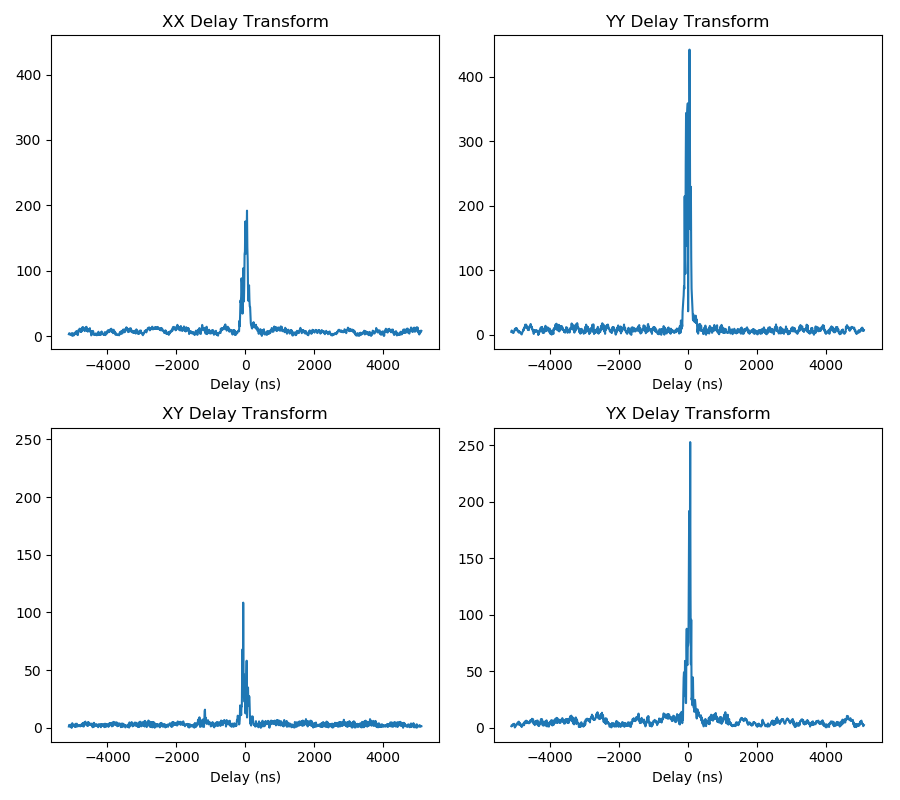

In [69]:
plt.figure(figsize=(9,8))

plt.subplot(221)
plt.plot(delaysxx,np.abs(vis_avg_delayxx))
plt.xlabel('Delay (ns)')
#plt.xlim(-900,-120) # zoom-in
plt.ylim(-20,460)
plt.title('XX Delay Transform')

plt.subplot(222)
plt.plot(delays,np.abs(vis_avg_delay))
plt.xlabel('Delay (ns)')
#plt.xlim(-900,-120) # zoom-in
#plt.ylim(0,600)
plt.title('YY Delay Transform')


plt.subplot(223)
plt.plot(delaysxy,np.abs(vis_avg_delayxy))
plt.xlabel('Delay (ns)')
#plt.xlim(-900,-120) # zoom-in
plt.ylim(-12,260)
plt.title('XY Delay Transform')

plt.subplot(224)
plt.plot(delaysyx,np.abs(vis_avg_delayyx))
plt.xlabel('Delay (ns)')
#plt.xlim(-900,-120) # zoom-in
#plt.ylim(0,600)
plt.title('YX Delay Transform')

plt.tight_layout()